# <center>Organizaci&oacute;n de Datos</center>
#### <center>C&aacute;tedra Ing. Rodriguez, Juan Manuel </center>
## <center>Trabajo Práctico 2 : Críticas Cinematográficas </center>
#### Grupo 29:
* Alen Davies Leccese - 107084
* Luca Lazcano - 107044

## Imports y carga de datos

In [144]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import sklearn as sk
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, KFold, RandomizedSearchCV, RepeatedStratifiedKFold
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, confusion_matrix, classification_report, make_scorer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.naive_bayes import MultinomialNB

import xgboost as xgb
from xgboost import XGBClassifier
import pickle
import re

import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

import tensorflow as tf
from tensorflow import keras
from keras.utils.vis_utils import plot_model
from keras.callbacks import EarlyStopping

from collections import Counter

RANDOM_STATE = 42

In [145]:
train = pd.read_csv('Datasets/train.csv')
test = pd.read_csv('Datasets/test.csv')

In [146]:
shape = train.shape
print("Filas: %d Columnas: %d" % (shape[0], shape[1]))

Filas: 50000 Columnas: 3


In [147]:
train.head()

,ID,review_es,sentimiento
0,0,Uno de los otros críticos ha mencionado que de...,positivo
1,1,Una pequeña pequeña producción.La técnica de f...,positivo
2,2,Pensé que esta era una manera maravillosa de p...,positivo
3,3,"Básicamente, hay una familia donde un niño peq...",negativo
4,4,"El ""amor en el tiempo"" de Petter Mattei es una...",positivo


## Preprocesamiento

Comenzamos por convertir a tipo str y a minúscula la columna ``'review_es'``

In [148]:
test['review_es'] = test['review_es'].astype(str).str.lower()
train['review_es'] = train['review_es'].astype(str).str.lower()
train.head()

,ID,review_es,sentimiento
0,0,uno de los otros críticos ha mencionado que de...,positivo
1,1,una pequeña pequeña producción.la técnica de f...,positivo
2,2,pensé que esta era una manera maravillosa de p...,positivo
3,3,"básicamente, hay una familia donde un niño peq...",negativo
4,4,"el ""amor en el tiempo"" de petter mattei es una...",positivo


### Tokenización

Usamos RegexpTokenizer de nltk para splitear las reviews en palabras. Usamos la expresión regular ``\w+`` que representa una expresión regular que coincide con una o más letras, números o guiones bajos.

In [149]:
regexp = RegexpTokenizer('\w+')

test['review_token'] = test['review_es'].apply(regexp.tokenize)
train['review_token'] = train['review_es'].apply(regexp.tokenize)
train.head()

,ID,review_es,sentimiento,review_token
0,0,uno de los otros críticos ha mencionado que de...,positivo,"[uno, de, los, otros, críticos, ha, mencionado..."
1,1,una pequeña pequeña producción.la técnica de f...,positivo,"[una, pequeña, pequeña, producción, la, técnic..."
2,2,pensé que esta era una manera maravillosa de p...,positivo,"[pensé, que, esta, era, una, manera, maravillo..."
3,3,"básicamente, hay una familia donde un niño peq...",negativo,"[básicamente, hay, una, familia, donde, un, ni..."
4,4,"el ""amor en el tiempo"" de petter mattei es una...",positivo,"[el, amor, en, el, tiempo, de, petter, mattei,..."


### Stopwords

Las stopwords (palabras vacías), son palabras muy comunes en un idioma que generalmente no aportan un significado importante al análisis de texto.

Las stopwords incluyen palabras como artículos ("el", "la", "los", "las"), pronombres ("yo", "tú", "él", "ella"), preposiciones ("a", "de", "en", "con").

Las stopwords se eliminan para reducir el ruido y el tamaño del vocabulario en el texto analizado, centrándose en las palabras clave. Al eliminar estas palabras vacías, se puede mejorar el rendimiento de algoritmos de procesamiento de texto.

In [150]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Luca\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [151]:
stopwords_es = nltk.corpus.stopwords.words("spanish")
print(stopwords_es)

['de', 'la', 'que', 'el', 'en', 'y', 'a', 'los', 'del', 'se', 'las', 'por', 'un', 'para', 'con', 'no', 'una', 'su', 'al', 'lo', 'como', 'más', 'pero', 'sus', 'le', 'ya', 'o', 'este', 'sí', 'porque', 'esta', 'entre', 'cuando', 'muy', 'sin', 'sobre', 'también', 'me', 'hasta', 'hay', 'donde', 'quien', 'desde', 'todo', 'nos', 'durante', 'todos', 'uno', 'les', 'ni', 'contra', 'otros', 'ese', 'eso', 'ante', 'ellos', 'e', 'esto', 'mí', 'antes', 'algunos', 'qué', 'unos', 'yo', 'otro', 'otras', 'otra', 'él', 'tanto', 'esa', 'estos', 'mucho', 'quienes', 'nada', 'muchos', 'cual', 'poco', 'ella', 'estar', 'estas', 'algunas', 'algo', 'nosotros', 'mi', 'mis', 'tú', 'te', 'ti', 'tu', 'tus', 'ellas', 'nosotras', 'vosotros', 'vosotras', 'os', 'mío', 'mía', 'míos', 'mías', 'tuyo', 'tuya', 'tuyos', 'tuyas', 'suyo', 'suya', 'suyos', 'suyas', 'nuestro', 'nuestra', 'nuestros', 'nuestras', 'vuestro', 'vuestra', 'vuestros', 'vuestras', 'esos', 'esas', 'estoy', 'estás', 'está', 'estamos', 'estáis', 'están', 'e

In [152]:
test['review_token'] = test['review_token'].apply(lambda x: [item for item in x if item not in stopwords_es])
train['review_token'] = train['review_token'].apply(lambda x: [item for item in x if item not in stopwords_es])
train.head()

,ID,review_es,sentimiento,review_token
0,0,uno de los otros críticos ha mencionado que de...,positivo,"[críticos, mencionado, después, ver, solo, 1, ..."
1,1,una pequeña pequeña producción.la técnica de f...,positivo,"[pequeña, pequeña, producción, técnica, filmac..."
2,2,pensé que esta era una manera maravillosa de p...,positivo,"[pensé, manera, maravillosa, pasar, tiempo, fi..."
3,3,"básicamente, hay una familia donde un niño peq...",negativo,"[básicamente, familia, niño, pequeño, jake, pi..."
4,4,"el ""amor en el tiempo"" de petter mattei es una...",positivo,"[amor, tiempo, petter, mattei, película, visua..."


In [153]:
stopwords_en = nltk.corpus.stopwords.words("english")
print(stopwords_en)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [154]:
test['review_token'] = test['review_token'].apply(lambda x: [item for item in x if item not in stopwords_en])
train['review_token'] = train['review_token'].apply(lambda x: [item for item in x if item not in stopwords_en])
train.head()

,ID,review_es,sentimiento,review_token
0,0,uno de los otros críticos ha mencionado que de...,positivo,"[críticos, mencionado, después, ver, solo, 1, ..."
1,1,una pequeña pequeña producción.la técnica de f...,positivo,"[pequeña, pequeña, producción, técnica, filmac..."
2,2,pensé que esta era una manera maravillosa de p...,positivo,"[pensé, manera, maravillosa, pasar, tiempo, fi..."
3,3,"básicamente, hay una familia donde un niño peq...",negativo,"[básicamente, familia, niño, pequeño, jake, pi..."
4,4,"el ""amor en el tiempo"" de petter mattei es una...",positivo,"[amor, tiempo, petter, mattei, película, visua..."


### Filtrado por largo del palabras

Ahora vamos a eliminar palabras poco frecuentes manteniendo solo las palabras que tienen más de 3 letras.

In [155]:
test['review_token'] = test['review_token'].apply(lambda x: [item for item in x if len(item) > 3])
train['review_token'] = train['review_token'].apply(lambda x: [item for item in x if len(item) > 3])
train.head()

,ID,review_es,sentimiento,review_token
0,0,uno de los otros críticos ha mencionado que de...,positivo,"[críticos, mencionado, después, solo, episodio..."
1,1,una pequeña pequeña producción.la técnica de f...,positivo,"[pequeña, pequeña, producción, técnica, filmac..."
2,2,pensé que esta era una manera maravillosa de p...,positivo,"[pensé, manera, maravillosa, pasar, tiempo, se..."
3,3,"básicamente, hay una familia donde un niño peq...",negativo,"[básicamente, familia, niño, pequeño, jake, pi..."
4,4,"el ""amor en el tiempo"" de petter mattei es una...",positivo,"[amor, tiempo, petter, mattei, película, visua..."


### Igualar palabras con o sin acento

In [156]:
# Sacar todas las tildes
def remove_tildes(text):
    tildes = {
        'á': 'a',
        'é': 'e',
        'í': 'i',
        'ó': 'o',
        'ú': 'u'
    }
    for key, value in tildes.items():
        text = text.replace(key, value)
    return text

In [157]:
test['review_token'] = test['review_token'].apply(lambda x: [remove_tildes(item) for item in x])
train['review_token'] = train['review_token'].apply(lambda x: [remove_tildes(item) for item in x])
train.head()

,ID,review_es,sentimiento,review_token
0,0,uno de los otros críticos ha mencionado que de...,positivo,"[criticos, mencionado, despues, solo, episodio..."
1,1,una pequeña pequeña producción.la técnica de f...,positivo,"[pequeña, pequeña, produccion, tecnica, filmac..."
2,2,pensé que esta era una manera maravillosa de p...,positivo,"[pense, manera, maravillosa, pasar, tiempo, se..."
3,3,"básicamente, hay una familia donde un niño peq...",negativo,"[basicamente, familia, niño, pequeño, jake, pi..."
4,4,"el ""amor en el tiempo"" de petter mattei es una...",positivo,"[amor, tiempo, petter, mattei, pelicula, visua..."


### Creación de vocabulario

TODO: explicar esto

In [ ]:
vocabulario = Counter()

for review in train['review_token']:
    for palabra in review:
        vocabulario[palabra] += 1


In [ ]:
len(vocabulario)

In [ ]:
vocab_size = 10000
vocabulario_truncado = [ word for word, count in vocabulario.most_common()[:vocab_size] ]

In [ ]:
len(vocabulario_truncado)

### Grafico las 20 palabras más frecuentes

In [ ]:
# Graficar las palabras más frecuentes con vocabulario_truncado.most_common(20)

top20 = pd.Series(dict(vocabulario.most_common(20)))
sns.barplot(y=top20.index, x=top20.values).set(title='Top 20 palabras más frecuentes', xlabel='Frecuencia', ylabel='Palabra')

plt.show()

### Filtrado de las que no están en el vocabulario truncado

In [ ]:
test['review_filtrado'] = test['review_token'].apply(lambda x: [item for item in x if item in vocabulario_truncado])
train['review_filtrado'] = train['review_token'].apply(lambda x: [item for item in x if item in vocabulario_truncado])
train.head()

### Truncado de las reviews

Acorto las reviews a las 300 primeras palabras.

In [ ]:
# guardo las 300 primeras palabras de cada review
test['review_filtrado_300'] = test['review_filtrado'].apply(lambda x: x[:300])
train['review_filtrado_300'] = train['review_filtrado'].apply(lambda x: x[:300])
train.head()

### Unión de review filtrado en string

In [ ]:
# join all words of each review into a string
test['review_filtrado_string'] = test['review_filtrado_300'].apply(lambda x: ' '.join(x))
train['review_filtrado_string'] = train['review_filtrado_300'].apply(lambda x: ' '.join(x))
train.head()

### Bag of Words

La técnica Bag of Words es una forma de representar datos de texto en aprendizaje automático. El concepto básico es tratar cada documento de texto como una "bolsa" de palabras, donde se ignora el orden y la estructura gramatical de las palabras. En lugar de eso, se enfoca únicamente en la presencia y frecuencia de las palabras en el texto.

Vamos a utilizar ``TfidfVectorizer`` de scikit-learn que implementa la técnica de ponderación TF-IDF (Term Frequency-Inverse Document Frequency) para convertir datos de texto en características numéricas.

In [ ]:
vectorizer = TfidfVectorizer()
train_fid = vectorizer.fit_transform(train.review_filtrado_string)
test_fid = vectorizer.transform(test.review_filtrado_string)

In [ ]:
print(train_fid)

In [ ]:
print(test_fid)

## Split train/test

Dvidimos el dataset en train y test.

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(train_fid,
                                                    train.sentimiento, 
                                                    test_size=0.3,
                                                    random_state=RANDOM_STATE, shuffle=True)

## Bayes Naive

Realizamos optimización de hiperparámetros con Random Search.

In [ ]:
#Cantidad de combinaciones que quiero probar
n=15

#Grilla de Parámetros a probar
params_grid={ 'alpha': [0.5, 1.0, 2.0, 5.0],
               'class_prior': [None, [0.1, 0.9], [0.2, 0.8], [0.3, 0.7], [0.4, 0.6], [0.5, 0.5], [0.6, 0.4]],
               'fit_prior': [True, False],
               'force_alpha': [True, False]
             }
                
#Cantidad de splits para el Cross Validation
folds=5

#Kfold estratificado
kfoldcv = StratifiedKFold(n_splits=folds, shuffle=True)

#Clasificador
NB_model = MultinomialNB()

# Metrica que quiero optimizar F1 Score
scorer_fn = make_scorer(sk.metrics.f1_score, pos_label='positivo')

#Random Search Cross Validation
rand_NB = RandomizedSearchCV(estimator = NB_model,
                              param_distributions = params_grid,
                              scoring = scorer_fn,
                              cv=kfoldcv,
                              n_iter = n,
                              random_state = RANDOM_STATE) 

rand_NB.fit(x_train, y_train)

Vemos cuales fueron los mejores hiperparámetros y la mejor métrica obtenida.

In [ ]:
print('Mejores parámetros: {}'.format(rand_NB.best_params_))
print('Mejor métrica: {}'.format(rand_NB.best_score_))

Entrenamos el modelo de Bayes Naive con los mejores hiperparámetros y realizamos las predicciones.

In [ ]:
NB_model = MultinomialNB().set_params(**rand_NB.best_params_)
NB_model.fit(x_train, y_train)

y_pred = NB_model.predict(x_test)

In [ ]:
print(f'Best Training Accuracy: {NB_model.score(x_train, y_train)}')
print(f'Best Testing Accuracy: {NB_model.score(x_test, y_test)}')

### Métricas

Calculamos las métricas de accuracy, precision, recall y f1-score.

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred, pos_label='positivo')
f1 = f1_score(y_test, y_pred, pos_label='positivo')
precision = precision_score(y_test, y_pred, pos_label='positivo')

print("Accuracy: "+str(accuracy))
print("Recall: "+str(recall))
print("Precision: "+str(precision))
print("f1 score: "+str(f1))

In [ ]:
#Reporte de Clasificación
print(classification_report(y_test, y_pred))

In [ ]:
#Matriz de Confusión
cm = confusion_matrix(y_test,y_pred)
sns.heatmap(cm, cmap='Blues',annot=True,fmt='g').set(title='Matriz de Confusión', xlabel='Predicted', ylabel='True', xticklabels=['negativo', 'positivo'], yticklabels=['negativo', 'positivo'])
plt.show()

### Submission

In [ ]:
pickle.dump(NB_model, open('NB_grupo29.pickle', 'wb'))

In [ ]:
X_submission_NB = test_fid
y_pred_test_NB = NB_model.predict(X_submission_NB)
df_submission_NB = pd.DataFrame({'ID': test['ID'], 'sentimiento': y_pred_test_NB})
df_submission_NB.to_csv('NB03.csv', index=False)

In [ ]:
label_map = {'negativo': 0, 'positivo': 1}
y_train = y_train.map(label_map)
y_test  = y_test.map(label_map)

In [ ]:
y_train.head()

In [ ]:
y_test.head()

## Random Forest

In [ ]:
#Cantidad de combinaciones que quiero probar
n=5

#Grilla de Parámetros
params_grid={ 'n_estimators': [100, 200, 300, 400, 500],
                'min_samples_split': [2, 5, 10, 15, 20, 25, 30, 35, 40],
                'max_depth': [None],
                'max_samples': [None, 0.5, 0.75, 0.9, 0.95, 0.99, 1.0],
                'ccp_alpha': [0.0, 0.001, 0.01, 0.1, 1.0],
             }

#Clasificador
rf_model = RandomForestClassifier(random_state=RANDOM_STATE)

# Metrica que quiero optimizar F1 Score
scorer_fn = make_scorer(sk.metrics.f1_score)

#Random Search Cross Validation
rand_rf = RandomizedSearchCV(estimator = rf_model,
                              param_distributions = params_grid,
                              scoring = scorer_fn,
                              n_iter = n,
                              random_state=RANDOM_STATE) 

rand_rf.fit(x_train, y_train)
rand_rf.cv_results_['mean_test_score'] 

In [ ]:
print('Mejores parámetros: {}'.format(rand_rf.best_params_))
print('Mejor métrica: {}'.format(rand_rf.best_score_))

In [ ]:
rf_model = RandomForestClassifier(random_state=RANDOM_STATE).set_params(**rand_rf.best_params_)
rf_model.fit(x_train, y_train)

y_pred = rf_model.predict(x_test)

In [ ]:
print(f'Best Training Accuracy: {rf_model.score(x_train, y_train)}')
print(f'Best Testing Accuracy: {rf_model.score(x_test, y_test)}')

### Métricas

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred, pos_label='positivo')
f1 = f1_score(y_test, y_pred, pos_label='positivo')
precision = precision_score(y_test, y_pred, pos_label='positivo')

print("Accuracy: "+str(accuracy))
print("Recall: "+str(recall))
print("Precision: "+str(precision))
print("f1 score: "+str(f1))

In [ ]:
#Reporte de Clasificación
print(classification_report(y_test, y_pred))

In [ ]:
#Matriz de Confusión
cm = confusion_matrix(y_test,y_pred)
sns.heatmap(cm, cmap='Blues',annot=True,fmt='g').set(title='Matriz de Confusión', xlabel='Predicted', ylabel='True', xticklabels=['negativo', 'positivo'], yticklabels=['negativo', 'positivo'])
plt.show()

### Submission

In [ ]:
pickle.dump(rf_model, open('rf_grupo29.pickle', 'wb'))

In [ ]:
X_submission_rf = test_fid
y_pred_test_rf = rf_model.predict(X_submission_rf)
y_pred_test_rf
df_submission_rf = pd.DataFrame({'ID': test['ID'], 'sentimiento': y_pred_test_rf})
df_submission_rf.to_csv('rf01.csv', index=False)

## XGBoost

In [ ]:
label_map = {'negativo': 0, 'positivo': 1}
y_train_mapped = y_train.map(label_map)
y_test_mapped = y_test.map(label_map)

In [ ]:
#Cantidad de combinaciones que quiero probar
n=5

#Grilla de Parámetros
params_grid= {'learning_rate': np.linspace(0.05, 0.5, 50),
                'gamma': [0,1,2],
                'max_depth': list(range(2,10)),
                'subsample': np.linspace(0, 1, 20),
                'lambda': [0,1,2],
                'alpha' : [1],
                'n_estimators': list(range(10,161,10))
              }

#Clasificador
xgb_model = XGBClassifier(random_state=RANDOM_STATE)

# Metrica que quiero optimizar F1 Score
scorer_fn = make_scorer(sk.metrics.f1_score)

#Random Search Cross Validation
rand_xgb = RandomizedSearchCV(estimator = xgb_model,
                              param_distributions = params_grid,
                              scoring = scorer_fn,
                              n_iter = n,
                              random_state=RANDOM_STATE) 

rand_xgb.fit(x_train, y_train_mapped)
rand_xgb.cv_results_['mean_test_score'] 

In [ ]:
print('Mejores parámetros: {}'.format(rand_xgb.best_params_))
print('Mejor métrica: {}'.format(rand_xgb.best_score_))

In [ ]:
xgb_model = XGBClassifier(random_state=RANDOM_STATE).set_params(**rand_xgb.best_params_)
xgb_model.fit(x_train, y_train)

y_pred = xgb_model.predict(x_test)

In [ ]:
print(f'Best Training Accuracy: {xgb_model.score(x_train, y_train)}')
print(f'Best Testing Accuracy: {xgb_model.score(x_test, y_test)}')

### Métricas

In [ ]:
accuracy = accuracy_score(y_test_mapped, y_pred)
recall = recall_score(y_test_mapped, y_pred)
f1 = f1_score(y_test_mapped, y_pred)
precision = precision_score(y_test_mapped, y_pred)

print("Accuracy: "+str(accuracy))
print("Recall: "+str(recall))
print("Precision: "+str(precision))
print("f1 score: "+str(f1))

In [ ]:
#Reporte de Clasificación
print(classification_report(y_test_mapped, y_pred))

In [ ]:
#Matriz de Confusión
cm = confusion_matrix(y_test_mapped, y_pred)
sns.heatmap(cm, cmap='Blues',annot=True,fmt='g').set(title='Matriz de Confusión', xlabel='Predicted', ylabel='True', xticklabels=['negativo', 'positivo'], yticklabels=['negativo', 'positivo'])
plt.show()

### Submission

In [ ]:
pickle.dump(xgb_model, open('xgb_grupo29.pickle', 'wb'))

In [ ]:
X_submission_xgb = test_fid
y_pred_test_xgb = xgb_model.predict(X_submission_xgb)

label_map = {0: 'negativo', 1: 'positivo'}
y_pred_test_xgb = y_pred_test_xgb.map(label_map)

df_submission_xgb = pd.DataFrame({'ID': test['ID'], 'sentimiento': y_pred_test_xgb})
df_submission_xgb.to_csv('xgb00.csv', index=False)

## Red Neuronal

### Tokenización y preprocesamiento

Debido a que las redes neuronales puede trabajar únicamente con datos numéricos, es necesario convertir de alguna forma las palabras a alguna representación numérica. Para esto, utilizamos la técnica de tokenización, que consiste en asignarle un número a cada palabra del vocabulario. Luego, cada review se representa como una secuencia de números, donde cada número representa una palabra.

Como ya vimos, la cantidad de palabras únicas es muy alta, y entrenar un modelo con tantos parámetros agrega costo computacional. Se puede limitar el "diccionario", o vocabulario conocido de la red a una cantidad más baja de palabras, que representan las más frecuentes. Para ello, a continuación seteamos este parámetro, en 10000, que es un valor que nos pareció razonable, y que no la performance del modelo.

In [249]:
VOCAB_SIZE = 1000

Además, considerando que algunas reviews son extremadamente largas, y leyendo algunas de ellas, concluimos que en general es posible determinar el sentimiento de una review con las primeras pocas cientos de palabras. Seteamos entonces el largo máximo de las reviews en 300 palabras.

In [250]:
REVIEW_MAX_LENGTH = 20

En la etapa de preprocesamiento, además, se eliminaron las stopwords, se igualaron las palabras con y sin acento, y se eliminaron las palabras con menos de 3 letras. Este preprocesamiento había quedado en la columna ```review_token```, el cual aprovecharemos aquí, pero sin la parte de codificación, largo de review y limitación del vocabulario, ya que eso lo hace el tokenizador de Keras. Preferimos mantener esa parte del procesamiento aquí. Por más que parezca redundate, de este modo tenemos un control más fino sobre el preprocesamiento para la red neuronal, y no afectamos los datos de los otros modelos.

Reconstruimos entonces las reviews en forma de strings a partir la columna ```review_token```

In [251]:
test['review_token_string_rnn'] = test['review_token'].apply(lambda x: ' '.join(x))
train['review_token_string_rnn'] = train['review_token'].apply(lambda x: ' '.join(x))
train.head()

,ID,review_es,sentimiento,review_token,review_token_string_rnn
0,0,uno de los otros críticos ha mencionado que de...,positivo,"[criticos, mencionado, despues, solo, episodio...",criticos mencionado despues solo episodio enga...
1,1,una pequeña pequeña producción.la técnica de f...,positivo,"[pequeña, pequeña, produccion, tecnica, filmac...",pequeña pequeña produccion tecnica filmacion i...
2,2,pensé que esta era una manera maravillosa de p...,positivo,"[pense, manera, maravillosa, pasar, tiempo, se...",pense manera maravillosa pasar tiempo semana v...
3,3,"básicamente, hay una familia donde un niño peq...",negativo,"[basicamente, familia, niño, pequeño, jake, pi...",basicamente familia niño pequeño jake piensa z...
4,4,"el ""amor en el tiempo"" de petter mattei es una...",positivo,"[amor, tiempo, petter, mattei, pelicula, visua...",amor tiempo petter mattei pelicula visualmente...


LLegamos entonces a la utilización de ```Tokenizer()```. Esta herramienta de Keras se encarga de tokenizar las reviews. Por defecto, separa los tokens (argumento ```split```) por espacios, los cual es suficiente para reviews en idioma español, donde las palabras están separadas por espacios. También tiene un filtro (argumento ```filters```) que elimna los signos de puntuación y otros símbolos que no aportan demasiado a la interpretación de una review.

El otro argumento importante, es el argumento ```oov_token```. "OOV" significa "Out Of Vocabulary", y se refiere a las palabras que no están en el vocabulario (recordemos que limitamos el largo del vocabulario, pero aún así, podemos tener en cuenta palabras poco frecuentes con los "buckets" de palabras fuera del vocabulario). Estos buckets agrupan las palabras poco comunes en "buckets" de palabras relacionadas. El tokenizador se encarga de llenar estos "buckets". En general, para estimar la cantidad de buckets, se utiliza un número en el rango del 2% al 5% del tamaño del vocabulario.

In [252]:
OOV_BUCKETS_FACTOR = 0.02
OOV_BUCKETS = int(VOCAB_SIZE * OOV_BUCKETS_FACTOR)

Luego, se encarga de codificar cada review como una secuencia de números, donde cada número representa una palabra del vocabulario. Para esto, se utiliza el método ```fit_on_texts()```, que recibe como parámetro una lista de reviews, y crea el vocabulario a partir de ellas. Luego, se utiliza el método ```texts_to_sequences()```, que recibe como parámetro una lista de reviews, y devuelve una lista de listas, donde cada lista representa una review, y cada número de la lista representa una palabra.

Creamos entonces el tokenizador con los parámetros establecidos.

In [253]:
tokenizer = keras.preprocessing.text.Tokenizer(num_words=VOCAB_SIZE, oov_token=f'<OOV>')

Lo fiteamos con las reviews previamente procesadas.

In [254]:
tokenizer.fit_on_texts(train['review_token_string_rnn'])

Podemos ver la cantidad de palabras únicas que encontró el tokenizador. Se deduce que la inmensa mayoría de las palabras quedarán fuera del vocabulario.

In [255]:
print(len(tokenizer.word_index))

168177


Convertimos la columna deseada a un array de numpy, para ser interpretado por los métodos de Keras.

In [256]:
reviews_lista_train = pd.Series(train['review_token_string_rnn']).to_numpy()
reviews_lista_test = pd.Series(test['review_token_string_rnn']).to_numpy()

In [257]:
print(reviews_lista_train[:3])

['criticos mencionado despues solo episodio enganchado razon exactamente sucedio conmigo primera cosa golpeo brutalidad escenas violencia inconfiadas encuentran derecha palabra confia espectaculo debiles corazon timido espectaculo extrae punzones respecto drogas sexo violencia hardcore clasico palabra llama apodo dado penitenciario seguridad maximo oswald centra principalmente ciudad emeralda seccion experimental prision todas celulas frentes vidrio enfrentan hacia adentro privacidad alta agenda city hogar fariarios musulmanes gangstas latinos cristianos italianos irlandeses esposas miradas muerte relaciones peligrosas acuerdos sombreados nunca lejos diria principal atractivo espectaculo debe hecho espectaculos atreverian olvidate imagenes bonitas pintadas audiencias convencionales olvidan encanto olviden romance mete primer episodio visto sorprendio desagradable surrealista podia decir listo ello observe desarrolle gusto acostumbre altos niveles violencia grafica solo violencia sino i

Para probar el resultado hasta ahora, podemos inventar un texto y ver a qué indices del vocabulario corresponden; o inventar secuencias de números y ver qué texto se genera.

In [258]:
tokenizer.texts_to_sequences(['criticos pelicula ijdrbsgds'])

[[937, 2, 1]]

Vemos que "criticos" y "pelicula" corresponden a índices del vocabulario, mientras que la secuencia aleatoria "ijdrbsgds", se guarda en el índice 1, que corresponde a los "buckets" de palabras fuera del vocabulario.

In [259]:
tokenizer.sequences_to_texts([[2, 1, 17, 235]])

['pelicula <OOV> vida episodio']

Guardamos entonces en ```encoded_train``` el resultado de codificar las reviews de entrenamiento, con el método ```texts_to_sequences()``` del tokenizador.

In [260]:
encoded_train = tokenizer.texts_to_sequences(reviews_lista_train)
encoded_test = tokenizer.texts_to_sequences(reviews_lista_test)

Otro paso clave antes de poder utilizar el modelo, es que todas las reviews deben tener el mismo largo. Para esto, utilizamos el método ```pad_sequences()```, que recibe las reviews codificadas. Si la review es más corta que el largo máximo, se rellena con ceros al final. Si la review es más larga que el largo máximo, se trunca al largo máximo. Aprovechamos este paso para setear el largo máximo de las reviews en el largo deseado.

In [261]:
encoded_train_truncado = tf.keras.preprocessing.sequence.pad_sequences(encoded_train, maxlen=REVIEW_MAX_LENGTH, truncating='post', padding='post', value=0)
encoded_test_truncado = tf.keras.preprocessing.sequence.pad_sequences(encoded_test, maxlen=REVIEW_MAX_LENGTH, truncating='post', padding='post', value=0)

Ahora, todas las reviews codificadas son arrays de números, todas del mismo largo. De este modo, podemos utilizarlas como entrada de la red neuronal, que necesita recibir un Tensor "denso", en vez de "ragged" (como sería el caso si no tuvieran todas el mismo largo).

Visualizamos algunas reviews codificadas, para ver como quedaron.

In [262]:
print(encoded_train_truncado[:5])

[[937   1  13   3 235   1 121 416 744   1  60 100   1   1  43 384   1 490
    1 491]
 [221 221 201   1   1   1 875   1 451   1   1  64   1  64 347  55 378   7
    1 282]
 [153  45 589 431  12 671   1  53   1   1 429 778   1   1  79   1 133   1
  131   1]
 [502 136 109 253   1 966   1   1 475   1  12   2   1   1   1   1 776   1
    1 508]
 [ 97  12   1   1   2   1 507   1 612   1   1 630   1   2  34   1 130 374
  306 137]]


### Split train / test

Llega el paso de spliteo de los datos codificados, que es el mismo que se viene utilizando en todos los modelos. Nada nuevo por acá.

In [263]:
x_train_rnn, x_test_rnn, y_train_rnn, y_test_rnn = train_test_split(encoded_train_truncado,
                                                                    train.sentimiento,
                                                                    test_size=0.3,
                                                                    random_state=RANDOM_STATE, shuffle=True)

Otro paso importante es mapear los sentimientos "negativo" y "positivo" a valores numéricos, ya que esta es la salida de una red neuronal. Discretizamos entonces la columna ```sentiment``` en 0 (negativo) y 1 (positivo).

In [264]:
label_map = {'negativo': 0, 'positivo': 1}
y_train_rnn = y_train_rnn.map(label_map)
y_test_rnn  = y_test_rnn.map(label_map)

Convertimos aquí el array de numpy a un tensor ragged de TensorFlow, para convertirlo a uno denso, para poder utilizarlo en el modelo.

In [265]:
x_train_rnn_ragged = tf.ragged.stack([tf.convert_to_tensor(lista) for lista in x_train_rnn], axis=0)
x_train_rnn_dense = x_train_rnn_ragged.to_tensor()
x_train_rnn_dense

<tf.Tensor: shape=(35000, 20), dtype=int32, numpy=
array([[  1,   1, 656, ..., 237, 133,   1],
       [ 87,   1,  14, ..., 757,   1,   1],
       [180, 339,   1, ...,   1,   1,   1],
       ...,
       [  1,   2, 187, ...,   5, 282, 738],
       [201,  23, 736, ...,   1, 157,  16],
       [  2, 450,  37, ...,   9,  46,   2]])>

### Parámetros y creación del modelo

A continuación se crea el modelo y se lo compila. En primer lugar, se utiliza una capa Embedding, que tendrá como parámetros:
 - Dimensión de entrada: tamaño del vocabulario más los buckets de palabras fuera del vocabulario.
 - Dimensión de salida: este valor es un hiperparámetro, que se puede optimizar. El tamaño de salida se llama "embed size", y es el tamaño de los vectores que representan a cada palabra. Entonces, si el "embed size" es de 128, significa que cada palabra estará representada por 128 parámetros entrenables. Estos permiten capturar relaciones entre palabras. A mayor tamaño, más detalle semántico se puede capturar. Entonces, cada palabra se puede pensar como una palabra en el espacio 128-dimensional, donde palabras más cercanas tienen mayor relación semántica.

In [266]:
EMBED_SIZE = 8
capa_embedding = keras.layers.Embedding(VOCAB_SIZE + OOV_BUCKETS, EMBED_SIZE, input_shape=[None])

La siguientes dos capas son GRU. Son variantes "simplificadas" de LSTM.

In [267]:
capa_gru_1 = keras.layers.GRU(4, return_sequences=True)
capa_gru_2 = keras.layers.GRU(4)

Por último, la capa de salida, que es una capa densa con una neurona, y función de activación sigmoidea. La salida de esta capa es un número entre 0 y 1, que representa la probabilidad de que la review sea positiva.

In [268]:
capa_salida = keras.layers.Dense(1, activation="sigmoid")

Creamos el modelo con las capas definidas.

In [269]:
rnn_model = keras.models.Sequential([
    capa_embedding,
    capa_gru_1,
    capa_gru_2,
    capa_salida
])

In [270]:
# rnn_model = keras.models.Sequential([
#     keras.layers.GRU(128, return_sequences=True, input_shape=[None, max_id],
#     dropout=0.2, recurrent_dropout=0.2),
#     keras.layers.GRU(128, return_sequences=True,
#     dropout=0.2, recurrent_dropout=0.2),
#     keras.layers.TimeDistributed(keras.layers.Dense(max_id,
#     activation="softmax"))
# ])

Presentamos un resumen del modelo.

In [271]:
rnn_model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_14 (Embedding)    (None, None, 8)           8160      
                                                                 
 gru_30 (GRU)                (None, None, 4)           168       
                                                                 
 gru_31 (GRU)                (None, 4)                 120       
                                                                 
 dense_15 (Dense)            (None, 1)                 5         
                                                                 
Total params: 8,453
Trainable params: 8,453
Non-trainable params: 0
_________________________________________________________________


Se compila el modelo, con la función de pérdida "binary crossentropy", el optimizador "adam" y la métrica "f1".

In [272]:
rnn_model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

Además, agregamos un callback "early stopping" para evitar el overfitting.

In [275]:
es = EarlyStopping(monitor='loss', patience=5) 

Se fitea el modelo:

In [277]:
EPOCHS = 5

In [278]:
history = rnn_model.fit(x_train_rnn_dense, y_train_rnn, batch_size=64, epochs=EPOCHS, callbacks=[es])

Epoch 1/5
  1/547 [..............................] - ETA: 14s - loss: 0.4080 - accuracy: 0.8281

547/547 [==============================] - 14s 26ms/step - loss: 0.5094 - accuracy: 0.7448
Epoch 2/5
547/547 [==============================] - 14s 26ms/step - loss: 0.5078 - accuracy: 0.7452
Epoch 3/5
547/547 [==============================] - 14s 25ms/step - loss: 0.5060 - accuracy: 0.7444
Epoch 4/5
547/547 [==============================] - 14s 26ms/step - loss: 0.5053 - accuracy: 0.7449
Epoch 5/5
547/547 [==============================] - 14s 25ms/step - loss: 0.5035 - accuracy: 0.7470


### Métricas

In [279]:
train_score = rnn_model.evaluate(x_train_rnn,
                       y_train_rnn,
                       verbose=1)
test_score = rnn_model.evaluate(x_test_rnn,
                       y_test_rnn,
                       verbose=1)
labels = rnn_model.metrics_names

print('')
print(f'Training Accuracy: {train_score[1]}')
print(f'Testing Accuracy: {test_score[1]}')

469/469 [==============================] - 3s 6ms/step - loss: 0.5553 - accuracy: 0.7132

Training Accuracy: 0.7558000087738037
Testing Accuracy: 0.7131999731063843


In [280]:
y_pred = rnn_model.predict(x_test_rnn)

469/469 [==============================] - 3s 4ms/step


In [281]:
y_pred_binario = np.where(y_pred > 0.5, 1, 0)

accuracy = accuracy_score(y_test_rnn, y_pred_binario)
recall = recall_score(y_test_rnn, y_pred_binario)
f1 = f1_score(y_test_rnn, y_pred_binario,)
precision = precision_score(y_test_rnn, y_pred_binario)

print("Accuracy: "  + str(accuracy))
print("Recall: "    + str(recall))
print("Precision: " + str(precision))
print("f1 score: "  + str(f1))

Accuracy: 0.7132
Recall: 0.777045724074318
Precision: 0.6931938403667568
f1 score: 0.7327286282306162


In [282]:
print(classification_report(y_test_rnn, y_pred_binario))

              precision    recall  f1-score   support

           0       0.74      0.65      0.69      7411
           1       0.69      0.78      0.73      7589

    accuracy                           0.71     15000
   macro avg       0.72      0.71      0.71     15000
weighted avg       0.72      0.71      0.71     15000



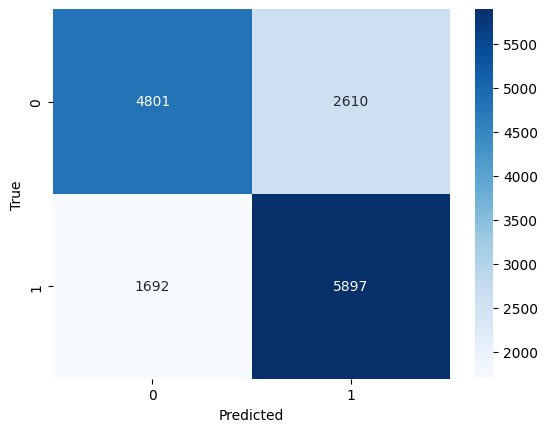

In [283]:
cm = confusion_matrix(y_test_rnn,y_pred_binario)
sns.heatmap(cm, cmap='Blues',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### Submission

In [284]:
pickle.dump(rnn_model, open('rnn_grupo29.pickle', 'wb'))

In [285]:
X_submission_rnn = encoded_test_truncado.tolist()
X_submission_rnn

[[128, 1, 2, 1, 15, 1, 458, 1, 1, 1, 1, 1, 1, 168, 1, 1, 1, 1, 1, 1],
 [1, 1, 524, 64, 185, 1, 76, 1, 699, 1, 1, 1, 1, 451, 1, 1, 1, 1, 2, 195],
 [1, 158, 207, 1, 1, 1, 1, 573, 1, 136, 359, 1, 1, 1, 1, 812, 541, 34, 1, 820],
 [1, 151, 405, 967, 1, 369, 167, 3, 485, 1, 1, 306, 1, 1, 1, 1, 1, 1, 2, 1],
 [1, 1, 3, 332, 1, 1, 1, 1, 1, 3, 1, 41, 3, 41, 3, 41, 3, 1, 7, 13],
 [1, 1, 1, 1, 1, 1, 33, 1, 1, 2, 376, 1, 376, 1, 810, 1, 11, 415, 1, 1],
 [473, 76, 96, 1, 1, 1, 1, 2, 329, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 [391, 2, 1, 735, 251, 151, 1, 636, 44, 1, 1, 1, 985, 1, 128, 22, 43, 1, 1, 1],
 [62, 599, 1, 1, 4, 1, 1, 79, 1, 86, 1, 1, 1, 85, 1, 51, 1, 1, 1, 192],
 [1, 1, 448, 151, 1, 362, 1, 1, 1, 1, 1, 1, 196, 1, 726, 1, 1, 1, 1, 1],
 [1, 1, 1, 1, 1, 234, 1, 1, 1, 1, 1, 953, 1, 1, 89, 55, 1, 1, 1, 193],
 [1, 180, 1, 1, 1, 158, 305, 1, 18, 160, 1, 158, 1, 1, 42, 1, 193, 1, 1, 1],
 [1, 1, 79, 1, 1, 528, 1, 1, 1, 10, 663, 1, 1, 1, 292, 1, 1, 1, 1, 1],
 [673, 1, 1, 1, 1, 1, 2, 1, 438, 639, 57, 1

In [286]:
y_pred_test_rnn = rnn_model.predict(X_submission_rnn)

269/269 [==============================] - 1s 5ms/step


In [287]:
y_pred_test_rnn_binario = np.where(y_pred_test_rnn > 0.5, 1, 0)
y_pred_test_rnn_binario

array([[1],
       [1],
       [1],
       ...,
       [1],
       [1],
       [1]])

In [288]:
label_map = {0: 'negativo', 1: 'positivo'}

y_pred_test_rnn_binario = pd.Series(y_pred_test_rnn_binario.flatten()).map(label_map).values
y_pred_test_rnn_binario

array(['positivo', 'positivo', 'positivo', ..., 'positivo', 'positivo',
       'positivo'], dtype=object)

In [289]:
df_submission_rnn = pd.DataFrame({'ID': test['ID'], 'sentimiento': y_pred_test_rnn_binario})
df_submission_rnn.to_csv('rnn00.csv', index=False)

## Ensamble